# Testing phase differences
This notebook analyzes the differences in phases of noisy input and the denoised target output.

A detailed analysis of this question can serve the ultimate goal of trying to find the optimal representation of the data: is it actually necessary to fit the amplitude and the phase or is the phase difference resulting from denoising neglectable?


## Imports
This notebook uses the custom code found in the code folder

In [1]:
import os

# math, processing, deep learning
import numpy as np
import tensorflow as tf
from scipy.signal import stft, istft

# visualization
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable


# custom code
from code.stftprocessing import StftDataset
from code.dsvisual import DatasetVisualizer

# convenience
from tqdm import tqdm
import datetime


2023-04-28 18:21:34.027894: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load the files for training and testing
There are different training and test sets in the folder. This section loads the appropriate ones into memory.


In [2]:
# this is a smaller training set for testing purposes
folder = "training/new_small"
base = "noisy_small"
target = "pure_small"

# this is a training set for training the main model
# folder = "training/original training"
# base = "noisy"
# target = "pure"

test_folder = "training/test set"
test_base = "noisy_test"
test_target = "pure_test"


Load the files from the given locations using the custom code StftDataset class.

The StftDataset class also processes the waveforms into STFT format.

In [3]:
noisy_stft = StftDataset()
pure_stft = StftDataset()

noisy_stft.load(folder, base)
pure_stft.load(folder, target)

# test sets
noisy_test_stft = StftDataset()
pure_test_stft = StftDataset()
noisy_test_stft.load(test_folder, test_base)
pure_test_stft.load(test_folder, test_target)

Files loaded.
Files loaded.
Files loaded.
Files loaded.


### Extracting phase information
The StftDataset class loads the data that was stored in amplitude and phase format in different files and combines it together

In [14]:
# get the phases of training and test sets
noisy_amplitudes = noisy_stft.get_data()[:,:,:,0]
noisy_phases = noisy_stft.get_data()[:,:,:,1]
pure_amplitudes = pure_stft.get_data()[:,:,:,0]
pure_phases = pure_stft.get_data()[:,:,:,1]


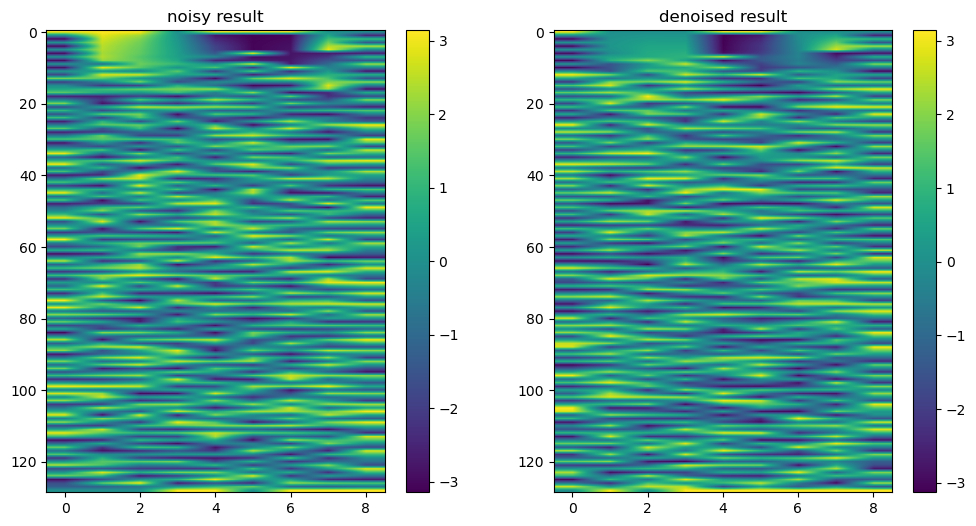

In [125]:
fig, [ax1, ax2] = plt.subplots(1,2)
# fig.set_size_inches(10,8)
ax1.set_title("noisy result")
ax2.set_title("denoised result")
im1 = ax1.imshow(noisy_phases[0], aspect="auto", interpolation="bilinear")
im2 = ax2.imshow(pure_phases[0], aspect="auto", interpolation="bilinear")
plt.colorbar(im1)
plt.colorbar(im2)

fig.set_size_inches(12,6)
plt.show()

# plt.colorbar()

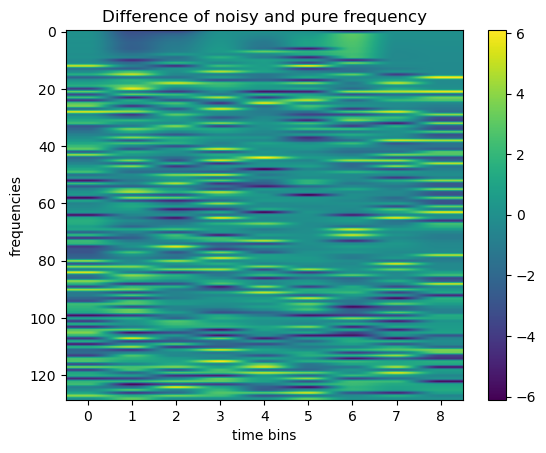

In [95]:
plt.imshow(pure_phases[0]-noisy_phases[0], aspect="auto")
plt.colorbar()
plt.title("Difference of noisy and pure frequency")
plt.ylabel("frequencies")
plt.xlabel("time bins")
plt.show()

## Recalculation of waveforms
The waveforms are calculated from inverse STFTs.

In [36]:
t, pure_waveforms = istft(pure_amplitudes * np.exp(1j*pure_phases))
t, noisy_waveforms = istft(noisy_amplitudes * np.exp(1j*noisy_phases))
t, mixed_waveforms = istft(pure_amplitudes * np.exp(1j*noisy_phases))

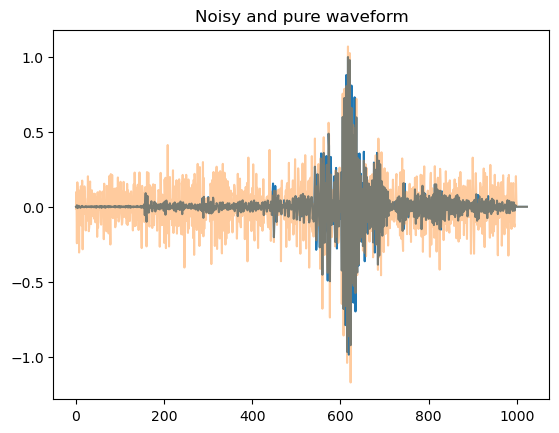

In [127]:
plt.plot(pure_waveforms[1])
plt.plot(noisy_waveforms[1], alpha=0.4)
plt.title("Noisy and pure waveform")
plt.show()

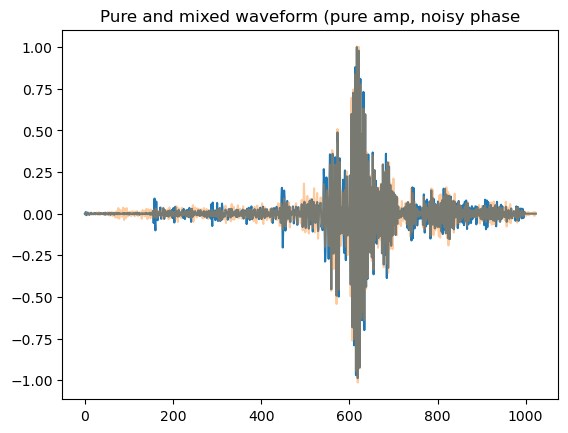

In [129]:
plt.title("Pure and mixed waveform (pure amp, noisy phase")
plt.plot(pure_waveforms[1])
plt.plot(mixed_waveforms[1], alpha=0.4)
plt.show()

## Assessing the waveforms
Pure waveforms and mixed waveforms.

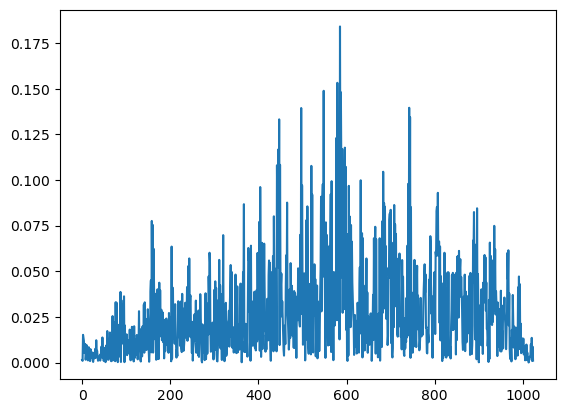

In [48]:
plt.plot(np.abs(pure_waveforms[1]-mixed_waveforms[1]))


In [51]:
np.mean(np.abs(pure_waveforms[1]-mixed_waveforms[1]))

0.02742314337902613

In [52]:
diff_mixed_pure = pure_waveforms-mixed_waveforms
absolute_difference = np.abs(diff_mixed_pure) 

In [64]:
absolute_difference.shape

(10000, 1024)

### Get the upper 10%
The upper 10% percentile gives a good estimate of the difference.

In [86]:
upper10_threshold = np.quantile(absolute_difference, [0.9], axis=1)
upper10_threshold = upper10_threshold.reshape(upper10_threshold.shape[1])
upper10_values = []
for i in range(absolute_difference.shape[0]):
    # print(i, values)
    new_value = absolute_difference[i][absolute_difference[i] > upper10_threshold[i]]
    upper10_values.append(new_value)
upper10_values =np.array(upper10_values)

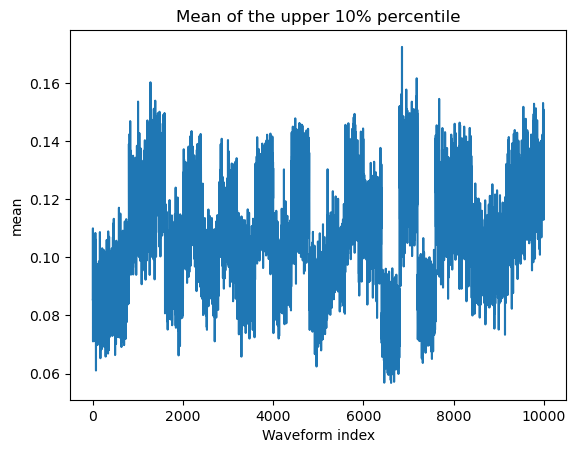

In [92]:
plt.plot(upper10_values.mean(axis=1))
plt.title("Mean of the upper 10% percentile")
plt.xlabel("Waveform index")
plt.ylabel("mean")
plt.show()

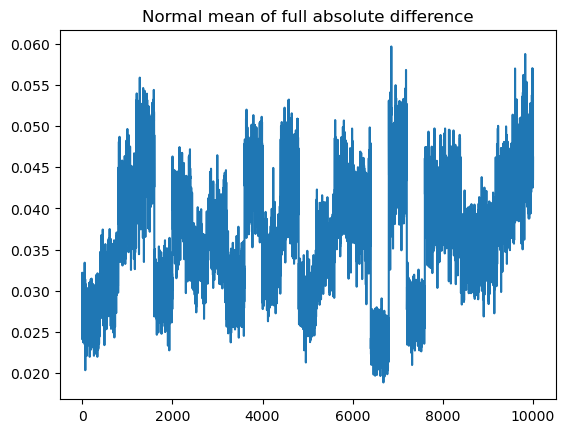

In [130]:
plt.title("Normal mean of full absolute difference")
plt.plot(absolute_difference.mean(axis=1))
plt.show()

In [44]:
var_diff = np.var(diff_mixed_pure, axis=1)

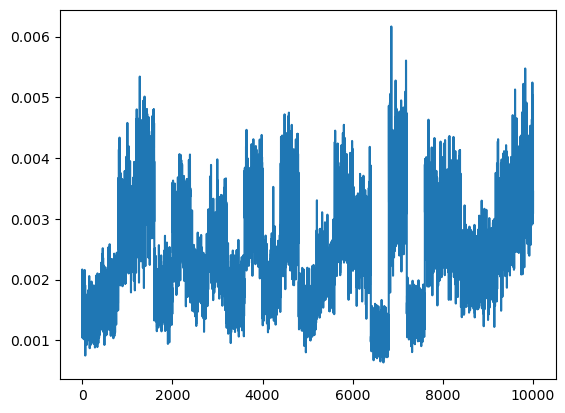

In [131]:
plt.plot(var_diff)
plt.show()

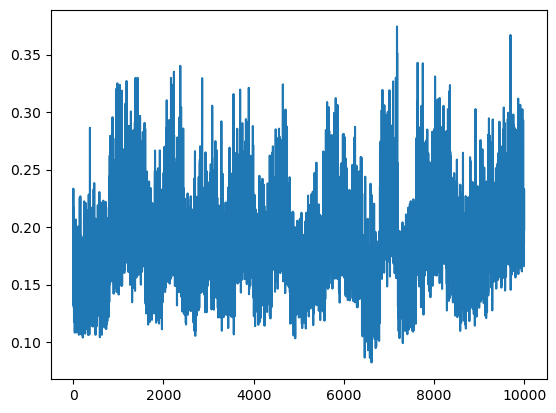

In [47]:
plt.plot(np.max(diff_mixed_pure, axis=1))

## Analyze effect of time bins
Potentially, the amount of different time bins might affect the strength of the error of the phase.

If there are more time bins, i.e. the waveform is split into more fine grained parts, this might lead to either smaller changes in the phase from noisy to denoised result or 

In [132]:
# todo: recalculate STFT with different time bins